In [1]:
# import relevant packages
from db_queries import get_outputs, get_ids
import pandas as pd
import numpy as np
from gbd_mapping import causes, risk_factors
from vivarium_inputs import get_measure
import gbd_mapping, vivarium_inputs, scipy.stats
from operator import attrgetter
from get_draws.api import get_draws
from math import sqrt, pi
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# these are the age groups and locations relevant to the anemia portion of the 
# large scale food fortification simulation project

# Note - additional validation required for other populations

locations = [163,214,179]
ages = [2,3,4,5]

In [3]:
# get global anemia impairment prevalence 
anemia = get_draws('rei_id', [192,205,206,207], source='como', measure_id=5, location_id=locations,
                   age_group_id=ages, year_id=2017, gbd_round_id=5)
anemia_all = anemia.where(anemia['cause_id'] == 294).dropna()
anemia_avg = anemia_all.set_index(['age_group_id','location_id', 'measure_id', 'rei_id',
                                 'sex_id', 'year_id', 'metric_id','cause_id'])
anemia_avg['avg'] = anemia_avg.mean(axis=1)
anemia_avg = anemia_avg.reset_index()
gbd_prepped = anemia_avg[['location_id','rei_id','age_group_id','sex_id','avg']]
gbd_prepped = gbd_prepped.rename(columns={'avg': 'prev'})
gbd_prepped.head()

,location_id,rei_id,age_group_id,sex_id,prev
0,163.0,192.0,2.0,1.0,0.711921
1,163.0,205.0,2.0,1.0,0.271431
2,163.0,206.0,2.0,1.0,0.410074
3,163.0,207.0,2.0,1.0,0.030416
4,163.0,192.0,3.0,1.0,0.711236


In [4]:
gbd_prepped = (pd.pivot_table(gbd_prepped, index=['age_group_id','sex_id','location_id'],
                     columns='rei_id', values='prev').reset_index()
        .rename(columns={192:'gbd_total',205:'gbd_mild',206:'gbd_moderate',207:'gbd_severe'}))
gbd_prepped.head()

rei_id,age_group_id,sex_id,location_id,gbd_total,gbd_mild,gbd_moderate,gbd_severe
0,2.0,1.0,163.0,0.711921,0.271431,0.410074,0.030416
1,2.0,1.0,179.0,0.815130,0.252845,0.513080,0.049205
2,2.0,1.0,214.0,0.769549,0.249367,0.473355,0.046827
3,2.0,2.0,163.0,0.633979,0.270099,0.342354,0.021526
4,2.0,2.0,179.0,0.760354,0.259541,0.458657,0.042156


In [5]:
# get means of hemoglobin distribution from REI ID 95
mean = get_draws('rei_id', 95, source='exposure', location_id=locations,
                 age_group_id=ages, year_id=2017, gbd_round_id=5)
mean_slim = mean.drop(columns=['measure_id','metric_id','modelable_entity_id','year_id'])
mean_slim = mean_slim.set_index(['location_id','age_group_id','sex_id'])
mean_slim['avg'] = mean_slim.mean(axis=1)
mean_fin = mean_slim.reset_index()
mean_fin = mean_fin[['location_id','age_group_id','sex_id','avg']]
mean_fin = mean_fin.rename(columns={'avg': 'mean'})
mean_fin.head()

,location_id,age_group_id,sex_id,mean
0,163,2,1,103.562593
1,163,3,1,118.013594
2,163,4,1,101.052542
3,163,5,1,106.013167
4,163,2,2,103.411572


In [6]:
# get standard deviation of hemoglobin distribution among iron-responsive causes 
sd = get_draws('modelable_entity_id', 10488, source='epi', location_id=locations,
               age_group_id=ages, year_id=2017, gbd_round_id=5)
sd_slim = sd.drop(columns=['measure_id','metric_id','modelable_entity_id','year_id','model_version_id'])
sd_slim = sd_slim.set_index(['location_id','age_group_id','sex_id'])
sd_slim['avg'] = sd_slim.mean(axis=1)
sd_fin = sd_slim.reset_index()
sd_fin = sd_fin[['location_id','age_group_id','sex_id','avg']]
sd_fin = sd_fin.rename(columns={'avg': 'sd'})
sd_fin.head()

,location_id,age_group_id,sex_id,sd
0,163,2,1,21.001543
1,163,3,1,15.591985
2,163,4,1,14.756635
3,163,5,1,13.870388
4,163,2,2,20.197449


In [7]:
# combine means and sds
merged = gbd_prepped.merge(mean_fin, right_on=['location_id','age_group_id','sex_id'], left_on=['location_id','age_group_id','sex_id'])
merged = merged.merge(sd_fin, right_on=['location_id','age_group_id','sex_id'], left_on=['location_id','age_group_id','sex_id'])
merged.head()

,age_group_id,sex_id,location_id,gbd_total,gbd_mild,gbd_moderate,gbd_severe,mean,sd
0,2.0,1.0,163.0,0.711921,0.271431,0.410074,0.030416,103.562593,21.001543
1,2.0,1.0,179.0,0.815130,0.252845,0.513080,0.049205,114.276220,15.540340
2,2.0,1.0,214.0,0.769549,0.249367,0.473355,0.046827,111.631776,15.791695
3,2.0,2.0,163.0,0.633979,0.270099,0.342354,0.021526,103.411572,20.197449
4,2.0,2.0,179.0,0.760354,0.259541,0.458657,0.042156,112.379897,14.825051


In [8]:
# define constants
EULERS_CONSTANT = 0.57721566490153286060651209008240243104215933593992
XMAX = 220
gamma_w = 0.4
m_gum_w = 0.6

In [9]:
# define anemia cut points
merged['mild_anemia_cut'] = np.where(merged['sex_id'] == 1, 130, 120)
merged['mild_anemia_cut'] = np.where(merged['age_group_id'].isin([2,3]), 150,
                               np.where(merged['age_group_id'].isin([4,5]), 110,
                                       np.where(merged['age_group_id'].isin([6,7]), 115, merged['mild_anemia_cut'])))
merged['mod_anemia_cut'] = 110
merged['mod_anemia_cut'] = np.where(merged['age_group_id'].isin([2,3]), 130,
                               np.where(merged['age_group_id'].isin([4,5]), 100, merged['mod_anemia_cut']))

merged['sev_anemia_cut'] = 80
merged['sev_anemia_cut'] = np.where(merged['age_group_id'].isin([2,3]), 90,
                               np.where(merged['age_group_id'].isin([4,5]), 70, merged['sev_anemia_cut']))

# define gamma distribution parameters
merged['gamma_shape'] = (merged['mean'] ** 2) / (merged['sd']**2)
merged['gamma_rate'] = merged['mean'] / (merged['sd']**2)

# define mirror gumbel distribution parameters
merged['mgum_alpha'] = XMAX - merged['mean'] - EULERS_CONSTANT*merged['sd']*sqrt(6)/pi
merged['mgum_scale'] = merged['sd']*sqrt(6)/pi

# calculate probability of anemia based on normal and ensesmble distribution assumptions

merged['gamma_dist_prev'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['mild_anemia_cut'])
merged['mir_gum_dist_prev'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['mild_anemia_cut'])
merged['ensemble_dist_prev']= gamma_w*merged['gamma_dist_prev'] + m_gum_w*merged['mir_gum_dist_prev']

merged['gamma_dist_prev_sev'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['sev_anemia_cut'])
merged['mir_gum_dist_prev_sev'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['sev_anemia_cut'])
merged['ensemble_dist_prev_sev']= gamma_w*merged['gamma_dist_prev_sev'] + m_gum_w*merged['mir_gum_dist_prev_sev']

merged['gamma_dist_prev_mod'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['mod_anemia_cut']) - merged['gamma_dist_prev_sev']
merged['mir_gum_dist_prev_mod'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['mod_anemia_cut']) - merged['mir_gum_dist_prev_sev']
merged['ensemble_dist_prev_mod']= gamma_w*merged['gamma_dist_prev_mod'] + m_gum_w*merged['mir_gum_dist_prev_mod']

merged['gamma_dist_prev_mild'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['mild_anemia_cut']) - merged['gamma_dist_prev_mod']
merged['mir_gum_dist_prev_mild'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['mild_anemia_cut']) - merged['mir_gum_dist_prev_mod']
merged['ensemble_dist_prev_mild']= gamma_w*merged['gamma_dist_prev_mild'] + m_gum_w*merged['mir_gum_dist_prev_mild']

merged.head()

,age_group_id,sex_id,location_id,gbd_total,gbd_mild,gbd_moderate,gbd_severe,mean,sd,mild_anemia_cut,...,ensemble_dist_prev,gamma_dist_prev_sev,mir_gum_dist_prev_sev,ensemble_dist_prev_sev,gamma_dist_prev_mod,mir_gum_dist_prev_mod,ensemble_dist_prev_mod,gamma_dist_prev_mild,mir_gum_dist_prev_mild,ensemble_dist_prev_mild
0,2.0,1.0,163.0,0.711921,0.271431,0.410074,0.030416,103.562593,21.001543,150,...,0.991122,0.271619,0.217492,0.239143,0.619336,0.722997,0.681532,0.358573,0.276934,0.309589
1,2.0,1.0,179.0,0.815130,0.252845,0.513080,0.049205,114.276220,15.540340,150,...,0.993508,0.050225,0.072922,0.063843,0.794401,0.799037,0.797182,0.189402,0.200941,0.196325
2,2.0,1.0,214.0,0.769549,0.249367,0.473355,0.046827,111.631776,15.791695,150,...,0.995012,0.077528,0.092353,0.086423,0.797693,0.825213,0.814205,0.189841,0.174784,0.180807
3,2.0,2.0,163.0,0.633979,0.270099,0.342354,0.021526,103.411572,20.197449,150,...,0.992718,0.264601,0.213043,0.233666,0.635454,0.739021,0.697594,0.346371,0.260959,0.295124
4,2.0,2.0,179.0,0.760354,0.259541,0.458657,0.042156,112.379897,14.825051,150,...,0.996167,0.057216,0.077803,0.069568,0.822785,0.846296,0.836892,0.167633,0.153703,0.159275


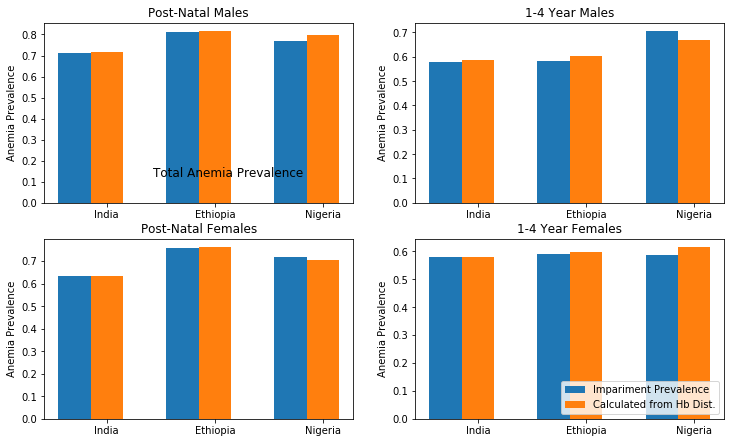

In [10]:
# total anemia

# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_total'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_total'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_total'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_total'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Total Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
#plt.tight_layout()

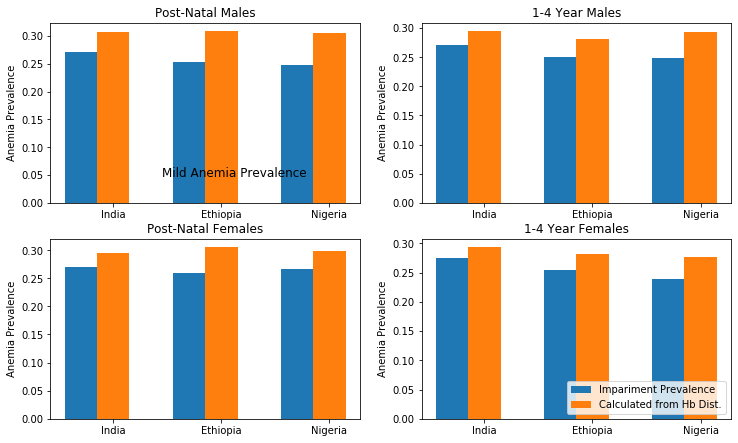

In [11]:
# MILD ANEMIA

# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_mild'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_mild'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_mild'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_mild'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Mild Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
#plt.tight_layout()

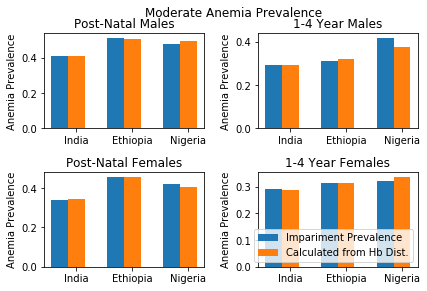

In [12]:
# MODERATE ANEMIA

# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_moderate'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_moderate'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_moderate'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_moderate'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Moderate Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()

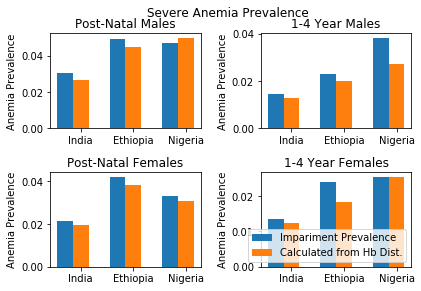

In [13]:
#SEVERE ANEMIA

# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_severe'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = merged['gbd_severe'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_severe'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = merged['gbd_severe'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Severe Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()